In [258]:
import torch
from data import load_traindata
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
from torch.utils.data import random_split
from scipy.spatial.distance import directed_hausdorff
from augmentation import augment

mps


In [259]:
torch.manual_seed(42)

In [260]:
num_subclasses = 1000
epochs = 1000
seq_size = 250
batch_size = 32
num_aug = 5
split_size=0.8
lr = 5e-5

In [261]:
X, _ = load_traindata(num_subclasses)
X = torch.tensor(X, dtype=torch.float32)
X = X.reshape(int(num_subclasses), int(1000 / seq_size), seq_size, 12)
X = X.reshape(int(num_subclasses * int(1000 / seq_size)), seq_size, 12)
train_size = int(split_size*len(X))
test_size = len(X) - train_size
X,X_test = random_split(X,[train_size, test_size])
X = augment(X)
X_input = X[:, :, 0]  # First channel
Y_target = X[:, :, 1]  # Second channel


X_test_tensors = [X_test.dataset[idx] for idx in range(len(X_test))] 
X_test_tensor = torch.stack(X_test_tensors) 
X_t = X_test_tensor[:, :, 0]  
Y_t = X_test_tensor[:, :, 1]

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, num_filters=32):  # Modified in_channels
        super(Generator, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv1d(in_channels, num_filters, 4, 2, 1),  # 500 → 250
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv1d(num_filters, num_filters * 2, 4, 2, 1),  # 250 → 125
            nn.BatchNorm1d(num_filters * 2),
            nn.LeakyReLU(0.2)
        )
        self.enc3 = nn.Sequential(
            nn.Conv1d(num_filters * 2, num_filters * 4, 4, 2, 1),  # 125 → 63
            nn.BatchNorm1d(num_filters * 4),
            nn.LeakyReLU(0.2)
        )
        self.enc4 = nn.Sequential(
            nn.Conv1d(num_filters * 4, num_filters * 8, 4, 2, 1),  # 63 → 32
            nn.BatchNorm1d(num_filters * 8),
            nn.LeakyReLU(0.2)
        )
        self.enc5 = nn.Sequential(
            nn.Conv1d(num_filters * 8, num_filters * 8, 4, 2, 1),  # 32 → 16
            nn.BatchNorm1d(num_filters * 8),
            nn.LeakyReLU(0.2)
        )
        self.enc6 = nn.Sequential(
            nn.Conv1d(num_filters * 8, num_filters * 8, 4, 2, 1),  # 16 → 8
            nn.BatchNorm1d(num_filters * 8),
            nn.LeakyReLU(0.2)
        )

        # Decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 8, num_filters * 8, 4, 2, 1),  # 8 → 16
            nn.BatchNorm1d(num_filters * 8),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 8, num_filters * 8, 4, 2, 1),  # 16 → 32
            nn.BatchNorm1d(num_filters * 8),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 8, num_filters * 4, 4, 2, 1),  # 32 → 63
            nn.BatchNorm1d(num_filters * 4),
            nn.ReLU()
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 4, num_filters * 2, 4, 2, 1, output_padding=1),  # 63 → 125
            nn.BatchNorm1d(num_filters * 2),
            nn.ReLU()
        )
        self.dec5 = nn.Sequential(
            nn.ConvTranspose1d(num_filters * 2, num_filters, 4, 2, 1),  # 125 → 250
            nn.BatchNorm1d(num_filters),
            nn.ReLU()
        )
        self.dec6 = nn.ConvTranspose1d(num_filters, out_channels, 4, 2, 1)  # 250 → 500
        self.final_activation = nn.LeakyReLU(0.2)  # Use Tanh for normalized output

    def match_size(self, x, target):
        diff = x.size(2) - target.size(2)
        if diff > 0:
            return x[:, :, :-diff]
        elif diff < 0:
            return nn.functional.pad(x, (0, -diff))
        else:
            return x

    def forward(self, x):
        # x shape: (batch_size, 2, seq_len)
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)

        d1 = self.match_size(self.dec1(e6), e5) + e5
        d2 = self.match_size(self.dec2(d1), e4) + e4
        d3 = self.match_size(self.dec3(d2), e3) + e3
        d4 = self.match_size(self.dec4(d3), e2) + e2
        d5 = self.match_size(self.dec5(d4), e1) + e1
        d6 = self.dec6(d5)
        return self.final_activation(d6)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, seq_size, num_filters=32):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=num_filters, kernel_size=4, stride=2, padding=1)
        self.leakyRelu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv1d(num_filters, num_filters*2, 4, 2, 1)
        self.bn1 = nn.BatchNorm1d(num_filters*2)
        self.conv3 = nn.Conv1d(num_filters*2, num_filters*4, 4, 2, 1)
        self.bn2 = nn.BatchNorm1d(num_filters*4)
        self.conv4 = nn.Conv1d(num_filters*4, num_filters*8, 4, 2, 1)
        self.bn3 = nn.BatchNorm1d(num_filters*8)
        self.conv5 = nn.Conv1d(num_filters*8, num_filters*8, 4, 2, 1)
        self.bn4 = nn.BatchNorm1d(num_filters*8)
        self.conv6 = nn.Conv1d(num_filters*8, 1, 4, 2, 1)
        self.op = nn.Linear(3, 1)  # Correct input size
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyRelu(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.leakyRelu(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.leakyRelu(x)
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.leakyRelu(x)
        x = self.conv5(x)
        x = self.bn4(x)
        x = self.leakyRelu(x)
        x = self.conv6(x)
        x = self.leakyRelu(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.op(x)
        x = self.sigmoid(x)
        return x

In [ ]:
dataset = TensorDataset(X_input, Y_target)
test_dataset = TensorDataset(X_t, Y_t)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
generator = Generator().to(device)
discriminator = Discriminator(seq_size).to(device)
#criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0005)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
print(sum(p.numel() for p in generator.parameters())/1e6, 'M parameters for Generator')
print(sum(p.numel() for p in discriminator.parameters())/1e6, 'M parameters for Discriminator')

1.398145 M parameters for Generator
0.437605 M parameters for Discriminator


In [ ]:
def plot_losses(d_losses, g_losses):
    def smooth_curve(points, factor=0.9):
        smoothed = []
        for point in points:
            if smoothed:
                smoothed.append(smoothed[-1] * factor + point * (1 - factor))
            else:
                smoothed.append(point)
        return smoothed

    plt.plot(smooth_curve(d_losses), label='D Loss')
    plt.plot(smooth_curve(g_losses), label='G Loss')
    plt.legend()
    plt.show()

In [ ]:
counter = 0
def plotWave(X, Y, c=0):
    x_np = X.squeeze(0).detach().cpu().numpy()
    y_np = Y.squeeze(0).detach().cpu().numpy()

    # Plotting
    plt.figure(figsize=(20, 6))
    plt.plot(x_np, color='blue', label='X (Generated Signal)')
    plt.plot(y_np, color='red', label='Y (Real Signal)')
    plt.legend()
    plt.title(f'Wave Comparison - Frame {c}')
    plt.show()

    # MSE
    mse = np.mean((x_np - y_np) ** 2)
    # FD
    fd = max(directed_hausdorff(x_np.reshape(-1, 1), y_np.reshape(-1, 1))[0],
             directed_hausdorff(y_np.reshape(-1, 1), x_np.reshape(-1, 1))[0])

    print(f"Frame {c}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Fréchet Distance: {fd:.4f}")

    return c + 1


In [ ]:
def l1_loss(x,y):
    return torch.mean(torch.abs(x - y))

Epoch 1/1000, Discrimiator Loss: 0.35959261655807495, Generator Loss: 1.3248913288116455
Epoch 2/1000, Discrimiator Loss: 0.20562799274921417, Generator Loss: 2.945984125137329
Epoch 3/1000, Discrimiator Loss: 0.17331664264202118, Generator Loss: 2.540419578552246
Epoch 4/1000, Discrimiator Loss: 0.18789426982402802, Generator Loss: 2.976710319519043
Epoch 5/1000, Discrimiator Loss: 0.031080670654773712, Generator Loss: 4.191991329193115
Epoch 6/1000, Discrimiator Loss: 0.08462975174188614, Generator Loss: 3.3285958766937256
Epoch 7/1000, Discrimiator Loss: 0.055547330528497696, Generator Loss: 4.315284729003906
Epoch 8/1000, Discrimiator Loss: 0.0909055694937706, Generator Loss: 2.443718671798706
Epoch 9/1000, Discrimiator Loss: 0.15373066067695618, Generator Loss: 2.8696885108947754
Epoch 10/1000, Discrimiator Loss: 0.05665092170238495, Generator Loss: 4.52116060256958
Epoch 11/1000, Discrimiator Loss: 0.043512605130672455, Generator Loss: 4.320855617523193
Epoch 12/1000, Discrimiato

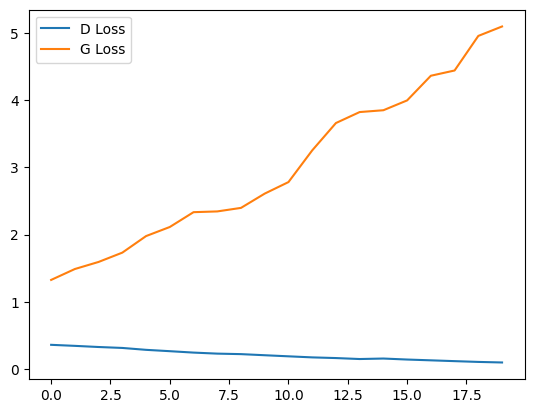

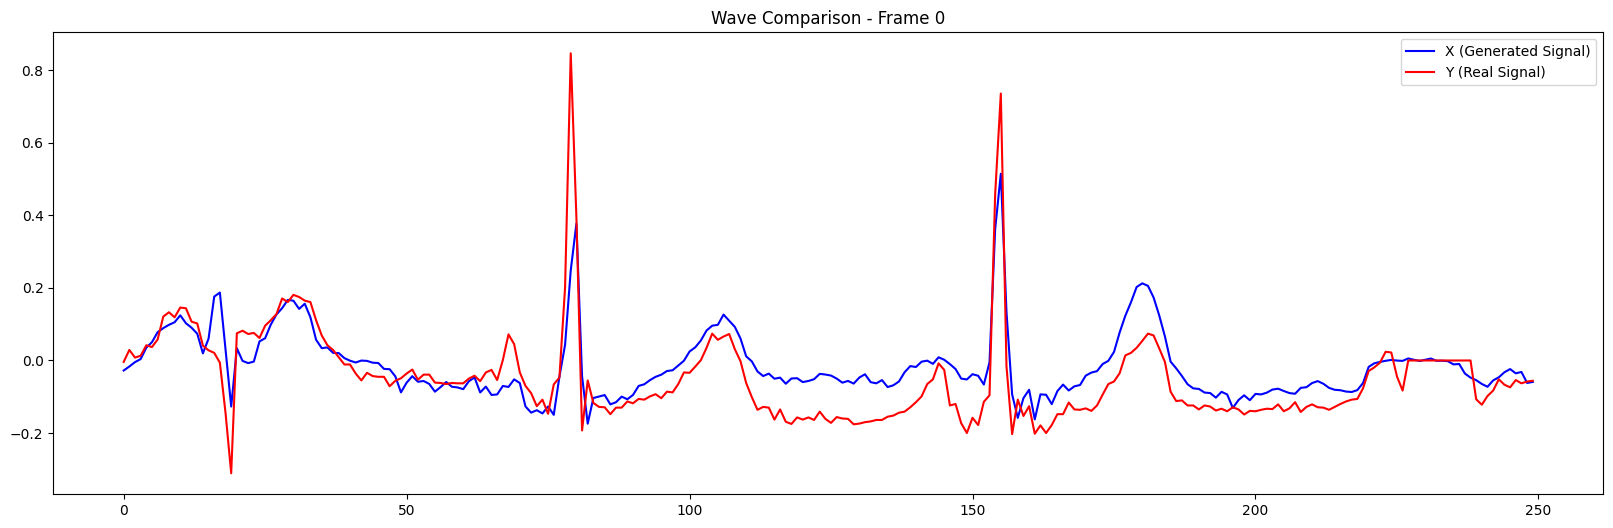

Frame 0:
Mean Squared Error (MSE): 0.0065
Fréchet Distance: 0.3322


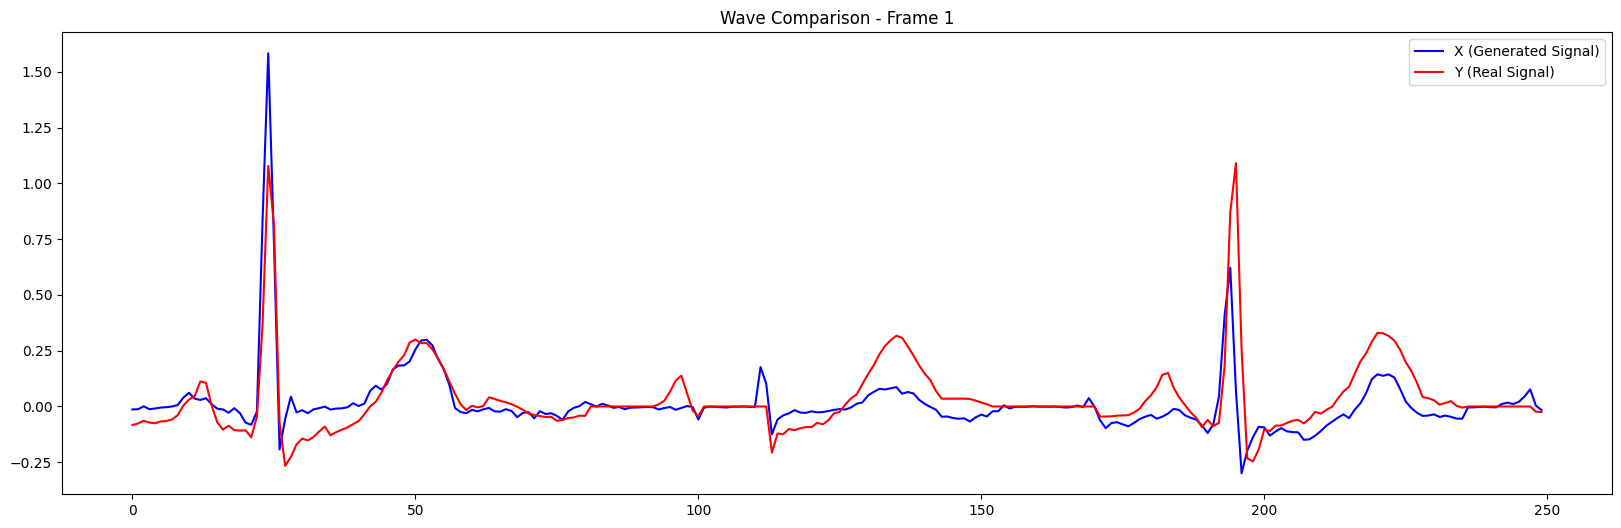

Frame 1:
Mean Squared Error (MSE): 0.0144
Fréchet Distance: 0.4927
Epoch 20/1000, Discrimiator Loss: 0.022378794848918915, Generator Loss: 6.357044219970703
Epoch 21/1000, Discrimiator Loss: 0.03057147189974785, Generator Loss: 4.3404388427734375
Epoch 22/1000, Discrimiator Loss: 0.14424079656600952, Generator Loss: 3.4700300693511963
Epoch 23/1000, Discrimiator Loss: 0.005460287909954786, Generator Loss: 3.743765354156494
Epoch 24/1000, Discrimiator Loss: 0.05923004820942879, Generator Loss: 0.6730884909629822
Epoch 25/1000, Discrimiator Loss: 0.08889051526784897, Generator Loss: 5.377542018890381
Epoch 26/1000, Discrimiator Loss: 0.019309058785438538, Generator Loss: 3.935197591781616
Epoch 27/1000, Discrimiator Loss: 0.057502321898937225, Generator Loss: 3.7509350776672363
Epoch 28/1000, Discrimiator Loss: 0.03980549797415733, Generator Loss: 4.113572597503662
Epoch 29/1000, Discrimiator Loss: 0.005752564407885075, Generator Loss: 8.480997085571289
Epoch 30/1000, Discrimiator Loss: 

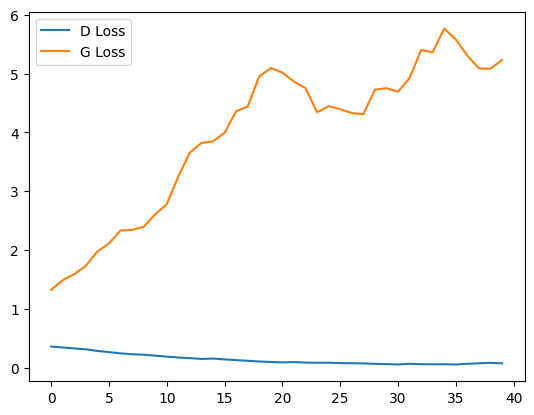

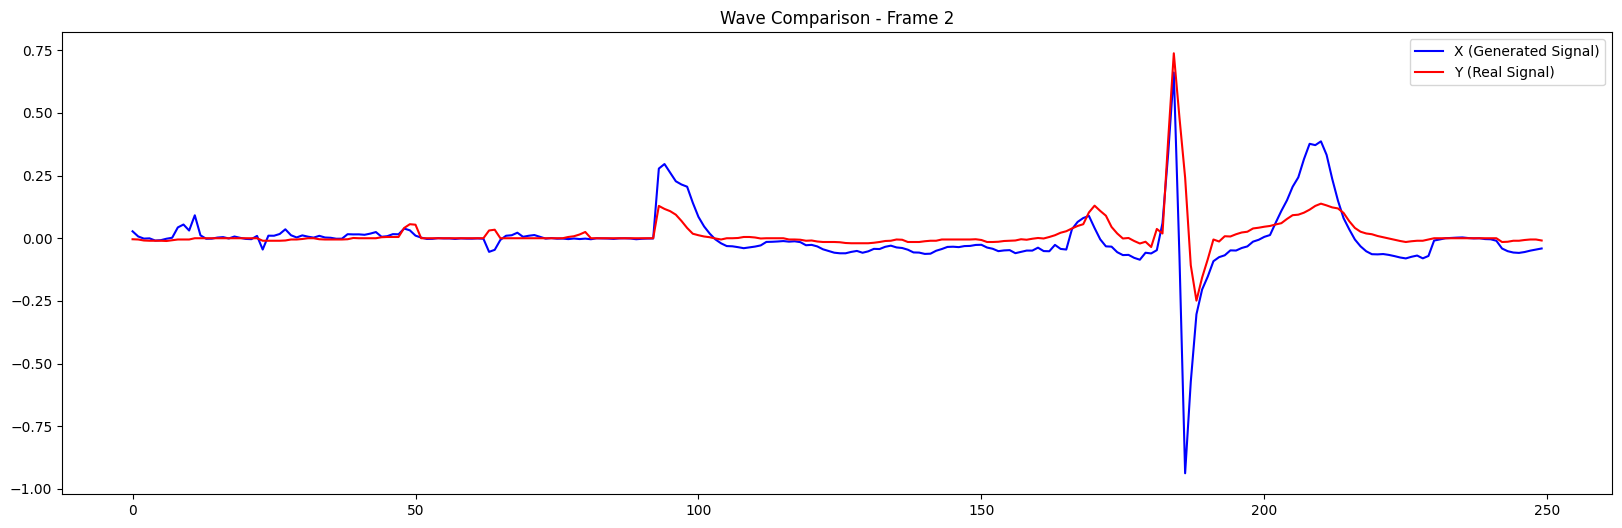

Frame 2:
Mean Squared Error (MSE): 0.0110
Fréchet Distance: 0.6888


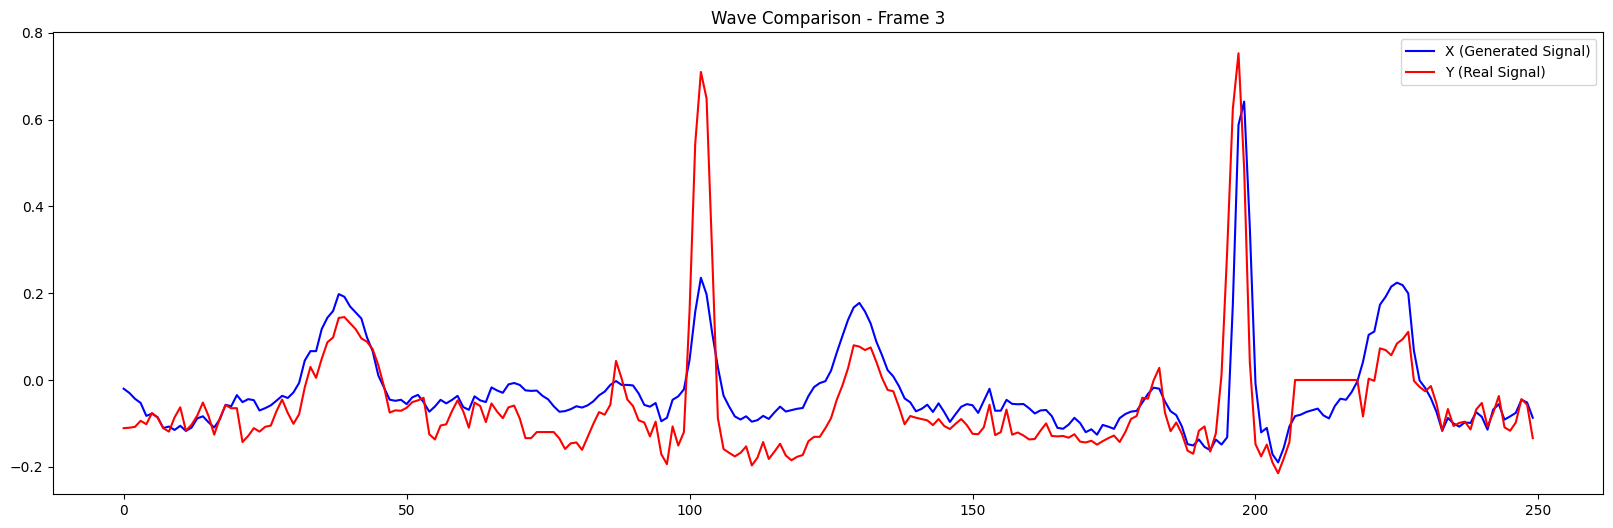

Frame 3:
Mean Squared Error (MSE): 0.0083
Fréchet Distance: 0.1114
Epoch 40/1000, Discrimiator Loss: 0.00558008486405015, Generator Loss: 6.5742011070251465
Epoch 41/1000, Discrimiator Loss: 0.012254975736141205, Generator Loss: 9.660964012145996
Epoch 42/1000, Discrimiator Loss: 0.0020694108679890633, Generator Loss: 8.5018310546875
Epoch 43/1000, Discrimiator Loss: 0.1998145878314972, Generator Loss: 13.750741004943848
Epoch 44/1000, Discrimiator Loss: 0.011419779621064663, Generator Loss: 3.720160961151123
Epoch 45/1000, Discrimiator Loss: 0.021114759147167206, Generator Loss: 10.745696067810059
Epoch 46/1000, Discrimiator Loss: 0.041373953223228455, Generator Loss: 8.374249458312988
Epoch 47/1000, Discrimiator Loss: 0.012846394442021847, Generator Loss: 5.972085952758789
Epoch 48/1000, Discrimiator Loss: 0.022742509841918945, Generator Loss: 7.2385454177856445
Epoch 49/1000, Discrimiator Loss: 0.09203275293111801, Generator Loss: 2.403592348098755
Epoch 50/1000, Discrimiator Loss: 

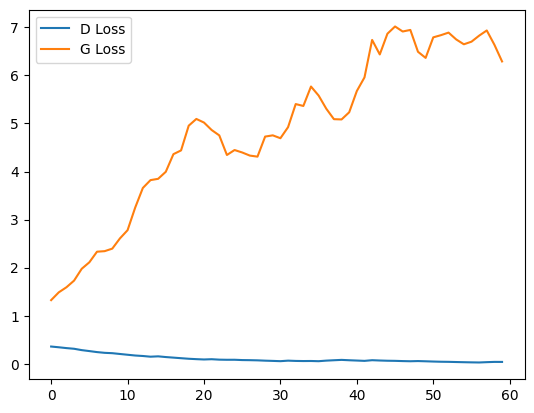

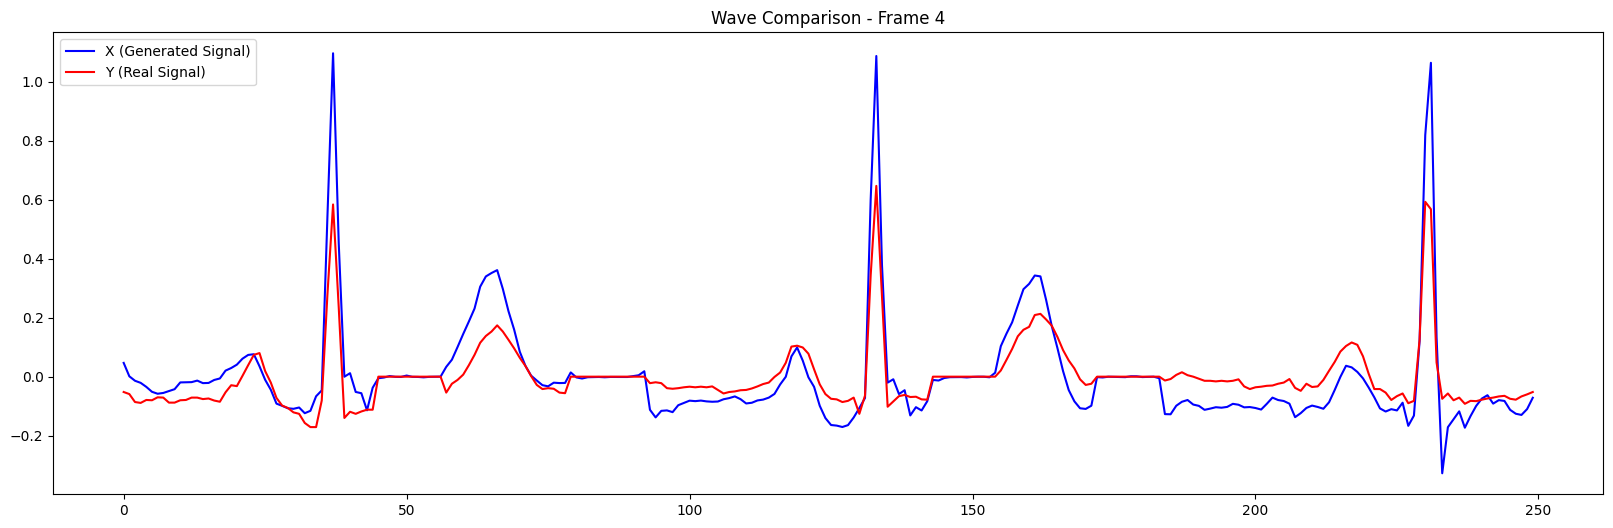

Frame 4:
Mean Squared Error (MSE): 0.0084
Fréchet Distance: 0.4497


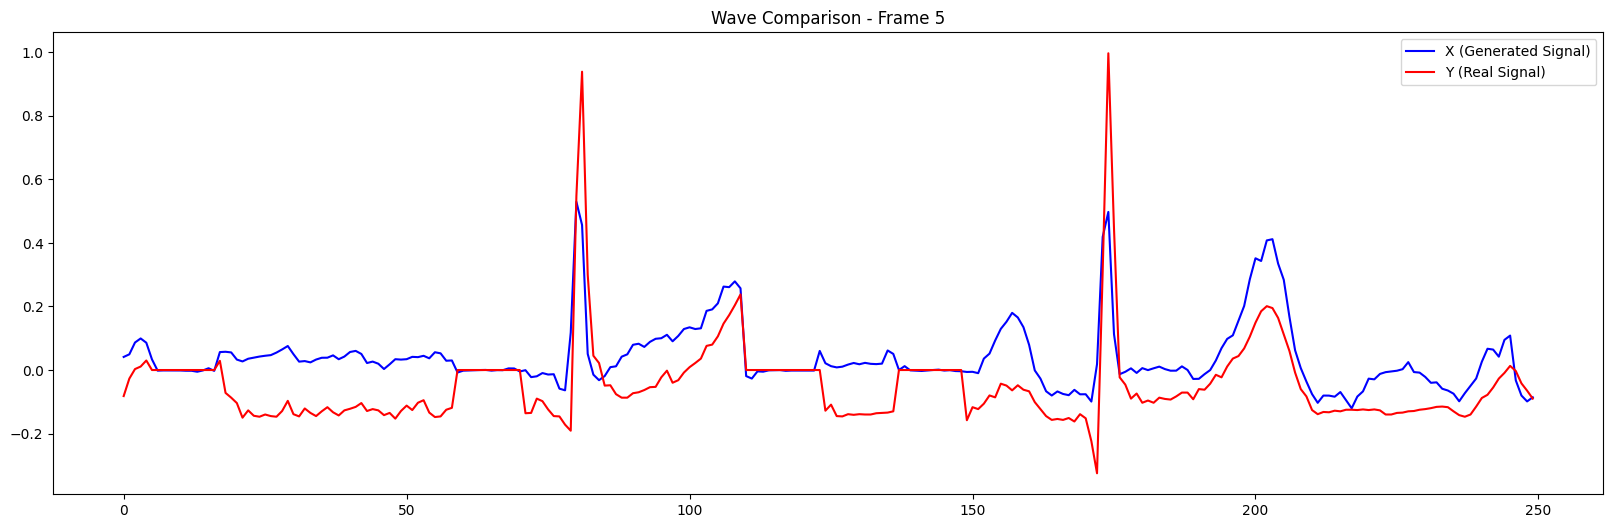

Frame 5:
Mean Squared Error (MSE): 0.0161
Fréchet Distance: 0.4676
Epoch 60/1000, Discrimiator Loss: 0.03410802409052849, Generator Loss: 3.167435884475708
Epoch 61/1000, Discrimiator Loss: 0.001329638878814876, Generator Loss: 7.870538234710693
Epoch 62/1000, Discrimiator Loss: 0.008797962218523026, Generator Loss: 7.353488922119141
Epoch 63/1000, Discrimiator Loss: 0.26551684737205505, Generator Loss: 5.738736629486084
Epoch 64/1000, Discrimiator Loss: 0.004648422356694937, Generator Loss: 6.123321533203125
Epoch 65/1000, Discrimiator Loss: 0.0004409623797982931, Generator Loss: 3.1754939556121826
Epoch 66/1000, Discrimiator Loss: 0.0534893162548542, Generator Loss: 2.9242141246795654
Epoch 67/1000, Discrimiator Loss: 0.00043464015470817685, Generator Loss: 6.4628801345825195


KeyboardInterrupt: 

In [ ]:
criterion = nn.BCELoss()
g_losses, d_losses = [], []
for epoch in range(epochs):
    for real_1, real_2 in dataloader:
        real_1, real_2 = real_1.to(device).float(), real_2.to(device).float()
        #real_2 += 0.01 * torch.randn_like(real_2)  # Noise augmentation
        # Train Discriminator
        optimizer_d.zero_grad()
        # Generate noise and condition
        noise = torch.randn_like(real_1)
        gen_input = torch.stack([real_1, noise], dim=1)  # (batch, 2, seq_len)
        fake_2 = generator(gen_input)
        # Real and fake inputs for discriminator
        d_real_input = torch.cat([real_2.unsqueeze(1), real_1.unsqueeze(1)], dim=1)
        d_fake_input = torch.cat([fake_2.detach(), real_1.unsqueeze(1)], dim=1)

        # Discriminator loss
        real_labels = torch.ones(real_1.size(0), 1, device=device)
        fake_labels = torch.zeros(real_1.size(0), 1, device=device)

        d_real_loss = criterion(discriminator(d_real_input), real_labels)
        d_fake_loss = criterion(discriminator(d_fake_input), fake_labels)
        d_loss = (d_real_loss + d_fake_loss)/2
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        gen_input = torch.stack([real_1, torch.randn_like(real_1)], dim=1)
        fake_2 = generator(gen_input)
        d_fake_input = torch.cat([fake_2, real_1.unsqueeze(1)], dim=1)
        g_loss = 0.9*criterion(discriminator(d_fake_input), real_labels)  + 0.1 * l1_loss(fake_2, real_2)
        g_loss.backward()
        optimizer_g.step()
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    if (epoch+1)%20==0:
        plot_losses(d_losses, g_losses)
        with torch.no_grad():
            for real_1, real_2 in dataloader:   
                real_1, real_2 = real_1.to(torch.float32),real_2.to(torch.float32)
                real_1, real_2 = real_1.to(device), real_2.to(device)
                gen_input = torch.stack([real_1, torch.randn_like(real_1)], dim=1) 
                fake_2 = generator(gen_input)
                counter = plotWave(fake_2[0],real_2[0], counter)
                counter = plotWave(fake_2[12],real_2[12], counter) #random output
                break
    print(f"Epoch {epoch+1}/{epochs}, Discrimiator Loss: {d_loss.item()}, Generator Loss: {g_loss.item()}")